In [1]:
import os
import cv2

import numpy as np 
from PIL import Image
import matplotlib.pyplot as plt 


# from utils import plot_img_2_pair, plot_hist_curve_2_pair, to_grayscale
from utils import *
from processing import apply_clahe

In [2]:
datasets = './data'
raw_dataset = f"{datasets}/raw-890/raw-890"
raw_ref_dataset = f"{datasets}/reference-890/reference-890"

def get_data_pair(idx):
    return f"{raw_dataset}/{idx}_img_.png", f"{raw_ref_dataset}/{idx}_img_.png"

In [3]:
path_raw, path_ref = get_data_pair(3)

In [4]:
img_bgr = cv2.imread(path_ref)
enhanced_img, histL, histCL = apply_clahe(path_raw, 10, (25,25))


## Gamma correction
- adjusts overall brightness in a non-linear way it lightens dark areas or darkens bright areas gently.

The corrected image is given by:

$$
I_{out} = 255 \times \left(\frac{I_{in}}{255}\right)^{\gamma}
$$

In [5]:
def apply_gamma_correction(image, gamma=None):
    # gray = to_grayscale(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist_before = cv2.calcHist([gray], [0], None, [256], [0, 256])

    if gamma is None:
        mean_intensity = np.mean(gray) / 255.0
        gamma = np.log(0.5) / np.log(mean_intensity + 1e-8)
        gamma = np.clip(gamma, 0.5, 2.0)

    corrected = np.power(image / 255.0, gamma)
    corrected = np.uint8(np.clip(corrected * 255, 0, 255))

    gray_after = cv2.cvtColor(corrected, cv2.COLOR_BGR2GRAY)
    hist_after = cv2.calcHist([gray_after], [0], None, [256], [0, 256])

    return corrected, hist_before, hist_after, gamma



In [6]:
gamma_corrected_img, hist_bef_gc,hist_aft_gc, gamma = apply_gamma_correction(enhanced_img)
print(f"Applied gamma correction with gamma = {gamma:.2f}")

Applied gamma correction with gamma = 0.93


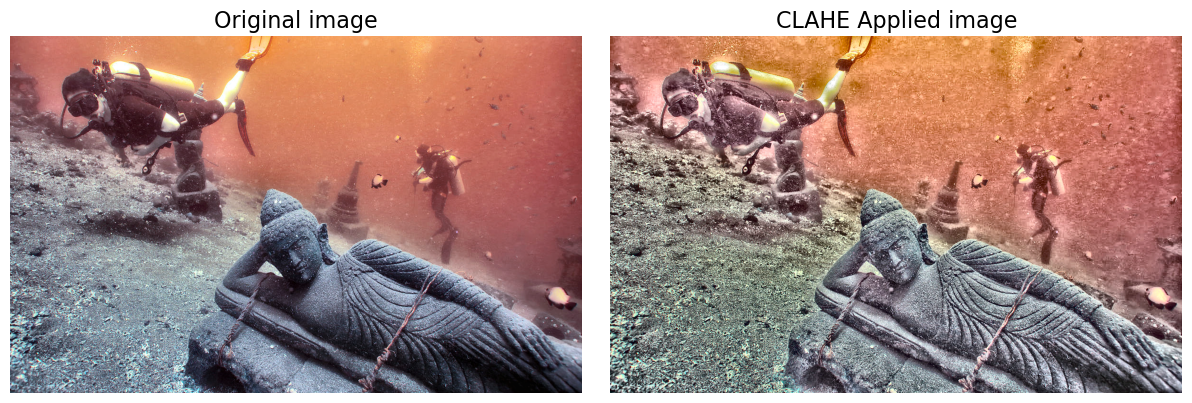

In [7]:
plot_img_2_pair(
    img_bgr,
    gamma_corrected_img,
    title1="Original image",
    title2="CLAHE Applied image",
)

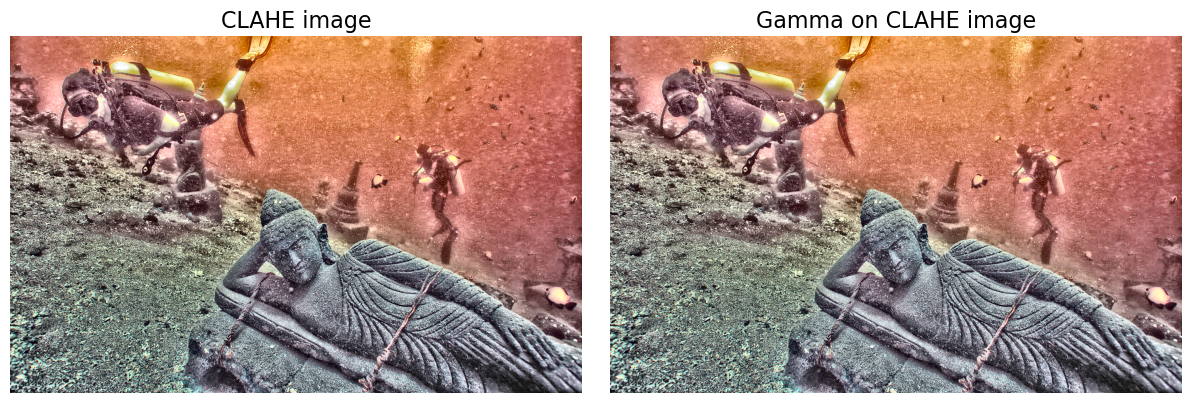

In [8]:
plot_img_2_pair(
    enhanced_img,
    gamma_corrected_img,
    title1="CLAHE image",
    title2="Gamma on CLAHE image",
)

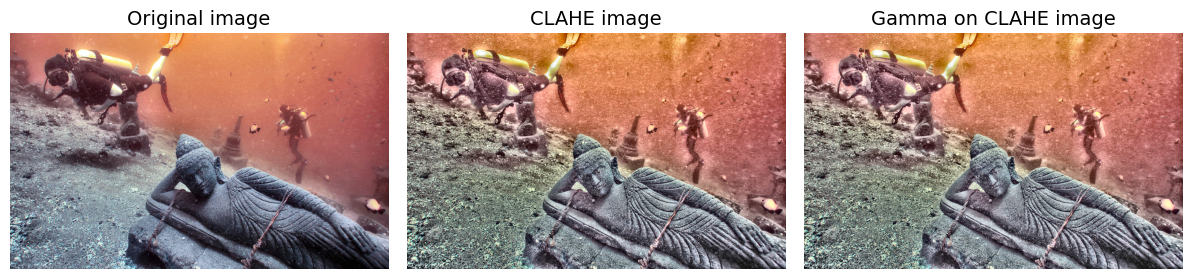

In [9]:
plot_img_3_pair(
    img_bgr,
    enhanced_img,
    gamma_corrected_img,
    title1="Original image",
    title2="CLAHE image",
    title3="Gamma on CLAHE image",
)

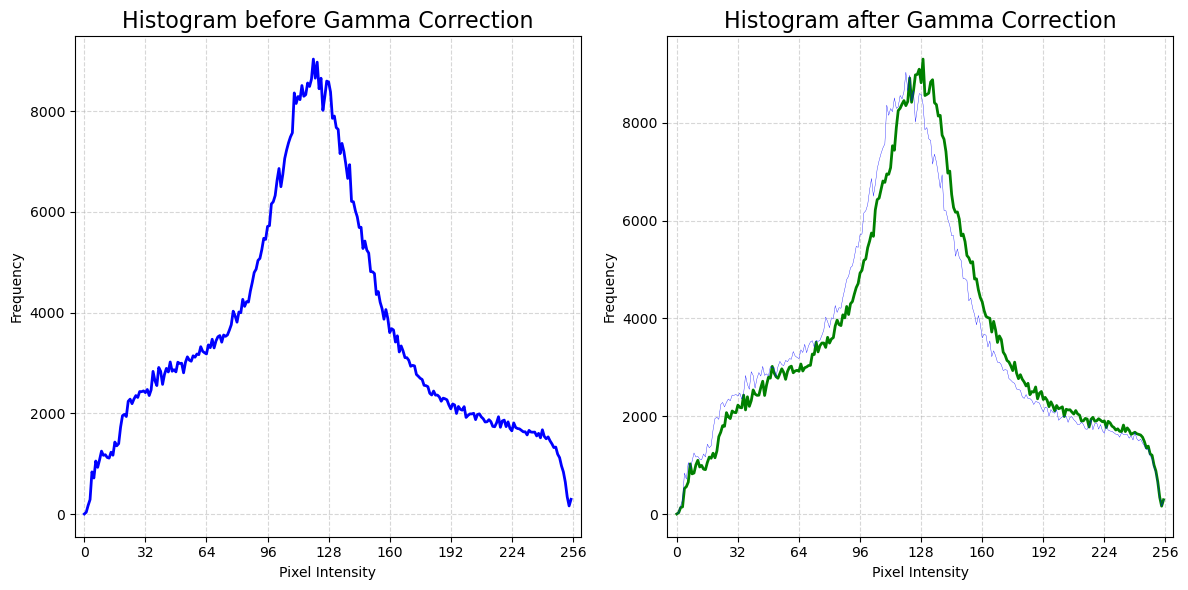

In [10]:
plot_hist_curve_2_pair(
    hist_bef_gc,hist_aft_gc,
    "Histogram before Gamma Correction",
    "Histogram after Gamma Correction",
    overlay_1_on_2 = True,
)

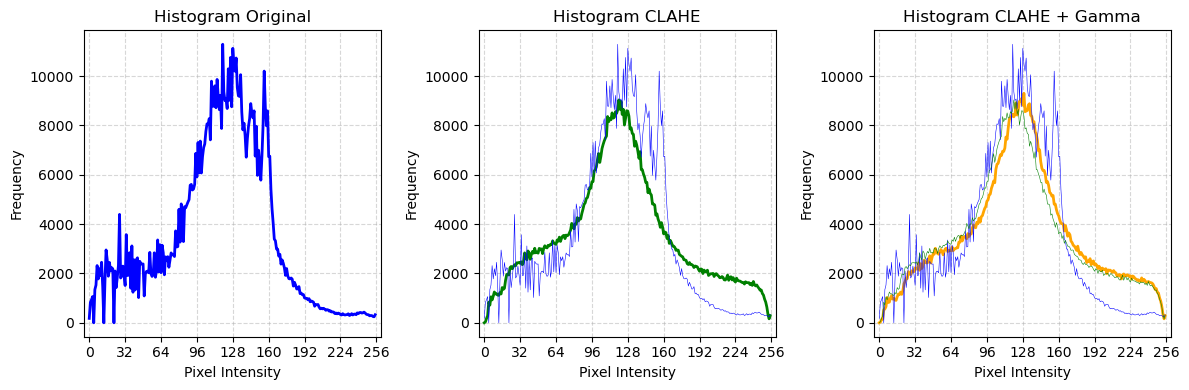

In [11]:
plot_hist_curve_3_pair(
    histL, hist_bef_gc,hist_aft_gc,
    "Histogram Original",
    "Histogram CLAHE",
    "Histogram CLAHE + Gamma",
    overlay_1_on_2 = True,
    overlay_1_on_3 = True,
    overlay_2_on_3 = True,
    overlay_alpha = 0.39,
)